In [3]:
# load packages and data
library(data.table) 
library(ggplot2)
library(dplyr) # if not installed locally, in command prompt use "conda install -c r r-dplyr"
library(tidyr)
library(stargazer)

# change deafult plot sizes
options(repr.plot.width=4, repr.plot.height=3)

# load data
loadDir = './Data/' # set directory where data will be loaded from
loadFName = 'Make 18_full.csv' # set file name of Qualtrics csv
rawData <- data.table::fread(input = paste(loadDir, loadFName, sep=''))

# also load in data from AMT to match MIDs (to download: on AMT site > Review Results > Download CSV)
amtIDs = data.table::fread(input = paste(loadDir, 'Make 18_full_AMT.csv' , sep=''), select='WorkerId') 

dataStartRow = 75 # set the row number when full experiment starts (used to exclude MIDs from past pilot runs)


Warning message in data.table::fread(input = paste(loadDir, "Make 18_full_AMT.csv", :
"Detected 30 column names but the data has 28 columns. Filling rows automatically. Set fill=TRUE explicitly to avoid this warning."

In [3]:
head(rawData)

StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,q1_txt,q2_txt,q3_txt,q4_txt,q5_txt,surveycode,MID,p1_txt,p2_txt,Random
Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,q1_txt,q2_txt,q3_txt,q4_txt,q5_txt,surveycode,MID,p1_txt,p2_txt,Random
"{""""ImportId"""":""""startDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""endDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""status""""}","{""""ImportId"""":""""ipAddress""""}","{""""ImportId"""":""""progress""""}","{""""ImportId"""":""""duration""""}","{""""ImportId"""":""""finished""""}","{""""ImportId"""":""""recordedDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""_recordId""""}","{""""ImportId"""":""""recipientLastName""""}",...,"{""""ImportId"""":""""q1_txt""""}","{""""ImportId"""":""""q2_txt""""}","{""""ImportId"""":""""q3_txt""""}","{""""ImportId"""":""""q4_txt""""}","{""""ImportId"""":""""q5_txt""""}","{""""ImportId"""":""""surveycode""""}","{""""ImportId"""":""""MID""""}","{""""ImportId"""":""""p1_txt""""}","{""""ImportId"""":""""p2_txt""""}","{""""ImportId"""":""""Random""""}"
2021-07-09 22:36:19,2021-07-09 22:37:51,Survey Preview,,100,91,True,2021-07-09 22:37:54,R_2YhLYlwEGxfIgCh,,...,NaN(5+7)*(10-8),NaN(11+13)*(6-5),NaN3+7*2,NaN10+8-7-5,NaN2+3+5+8,9348,,,,2
2021-07-09 22:39:36,2021-07-09 22:53:16,IP Address,157.51.62.60,100,820,True,2021-07-09 22:53:17,R_2e4IILDq5qEipzH,,...,NaN10+8/(6-7),NaN13+5,NaN7*2+(1*4),,NaN8*3-(5+7),1441,A33Z442WJQ8ADC,,,2
2021-07-09 22:38:07,2021-07-09 22:54:39,IP Address,201.47.22.214,100,992,True,2021-07-09 22:54:40,R_2U5fS9EqxPKlcze,,...,NaN3*6*(8-7),NaN5*6*(11-13),NaN2*7*(4-1),NaN3*7*(7-2),~+3*8*(2-5),7876,A2825I2XO6KZEP,,,1
2021-07-09 22:54:07,2021-07-09 23:00:33,IP Address,192.154.206.9,100,385,True,2021-07-09 23:00:34,R_1k0TzyF95z6apGi,,...,NaN33.6,NaN11+13+5/6,NaN1/2*4*7,NaN7/3*7*2,NaN2/8*3+5,9853,A35T79LLCN429G,,,2


In [45]:
# basic removals
cleanedData = rawData[-(1:dataStartRow), ] # remove all data from previous pilot runs
cleanedData = cleanedData[MID %in% amtIDs[, WorkerId], ] # keep only entries with AMT worker IDs that match those on Amazon interface
cleanedData = cleanedData[order(StartDate)] # reorder by ascending starting time

# print repeated IPs and MIDs
print('Repeated IPs:')
data.table(table(c(cleanedData[, IPAddress], 000)))[N>1, ] # use 000 as placemark so list is not empty
print('Repeated MIDs:')
data.table(table(c(cleanedData[, MID], 000)))[N>1, ]

# remove repeated IPs and MIDs
repeatedIPs = data.table(table(c(cleanedData[, IPAddress], 000)))[N>1, V1]
repeatedMIDs = data.table(table(c(cleanedData[, MID], 000)))[N>1, V1]

for (MID_i in repeatedMIDs) {
    cleanedData[which(cleanedData[, MID] == MID_i)[-1], ] = NA # remove data from duplicate MechTurk IDs (keep first data point)
}
for (IP_i in repeatedIPs) {
    cleanedData[which(cleanedData[, IPAddress] == IP_i)[-1], ] = NA # remove data from duplicate IPs (keep first data point)
}
cleanedData = na.omit(cleanedData)

'cleanedData Dimensions:'
dim(cleanedData)

[1] "Repeated IPs:"


V1,N
117.213.35.151,2
117.213.35.153,3
117.217.160.22,2
117.217.212.77,2
182.65.18.62,2
49.37.209.192,3
49.37.211.26,3
59.99.222.64,2


[1] "Repeated MIDs:"


V1,N
AFV9RX3T7ZHIB,2


[1] "cleanedData Dimensions:"

[1] 274 179

In [5]:
# check if any subjects did not finish the survey

cleanedData[Finished=='False', ]

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"

StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,q1_txt,q2_txt,q3_txt,q4_txt,q5_txt,surveycode,MID,p1_txt,p2_txt,Random


In [62]:
# coalesce control and treatment data into combined columns

numPuzzles = 5

defaultW <- getOption("warn") # suppress warnings that appear when coalescing
options(warn=-1)

# for each puzzle, coalesce the data (text and stress/confidence questions) from treatment and control into a single column
for (puzzleNum in c(1:numPuzzles)) {
    # create column names to get data from in each loop (i.e. for each puzzle)
    rt_colName_treat = paste('Q6.', toString(1+(puzzleNum-1)*5), '_Page Submit', sep='')
    rt_colName_control = paste('Q8.', toString(1+(puzzleNum-1)*5), '_Page Submit', sep='')
    rt_questions_colName_treat = paste('Q6.', toString(3+(puzzleNum-1)*5), '_Page Submit', sep='')
    rt_questions_colName_control = paste('Q8.', toString(3+(puzzleNum-1)*5), '_Page Submit', sep='')
    stress_colName_treat = paste('Q6.', toString(4+(puzzleNum-1)*5), '_1', sep='')
    stress_colName_control = paste('Q8.', toString(4+(puzzleNum-1)*5), '_1', sep='')
    confidence_colName_treat = paste('Q6.', toString(5+(puzzleNum-1)*5), '_1', sep='')
    confidence_colName_control = paste('Q8.', toString(5+(puzzleNum-1)*5), '_1', sep='')
    
    # coalesce the data for each puzzle question
    cleanedData[, paste('rt_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..rt_colName_treat])), as.numeric(unlist(cleanedData[, ..rt_colName_control])))]
    cleanedData[, paste('rt_questions_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..rt_questions_colName_treat])), as.numeric(unlist(cleanedData[, ..rt_questions_colName_control])))]
    cleanedData[, paste('stress_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..stress_colName_treat])), as.numeric(unlist(cleanedData[, ..stress_colName_control])))]
    cleanedData[, paste('confidence_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..confidence_colName_treat])), as.numeric(unlist(cleanedData[, ..confidence_colName_control])))]  
}

options(warn = defaultW)


# coalesce for treatment message page
cleanedData[, 'rt_treatMsg':=coalesce(as.numeric(unlist(cleanedData[, 'Q5.1_Page Submit'])), as.numeric(unlist(cleanedData[, 'Q7.1_Page Submit'])))]
cleanedData[, 'cc_treatMsg':=coalesce(as.numeric(unlist(cleanedData[, 'Q5.1_Click Count'])), as.numeric(unlist(cleanedData[, 'Q7.1_Click Count'])))]


### Rename Column Names

In [63]:
# rename columns

# rt = response time, cc = click count
##### change the key below if you want to use different column names:
renamedCols = c('IPAddress'='IP', 'Duration (in seconds)'='totTaskTime',
                'Q1.1_Page Submit'='rt_intro', 'Q1.1_Click Count'='cc_intro',
                'Q2.1'='gender', 'Q2.2'='age', 'Q2.3'='ethnicity', 'Q2.4'='education', 'Q2.5'='income', 'Q2.6'='intent', 'Q2.7_1'='mathEnjoyment',
                'Q3.1_Page Submit'='rt_instructions', 'Q3.1_Click Count'='cc_instructions', 
                'Q4.1_Page Submit'='rt_prac1', 'Q4.1_Click Count'='cc_prac1', 'p1_txt'='text_prac1',
                'Q4.3_Page Submit'='rt_prac2', 'Q4.3_Click Count'='cc_prac2', 'p2_txt'='text_prac2',
                'q1_txt'='text_q1', 'q2_txt'='text_q2', 'q3_txt'='text_q3', 'q4_txt'='text_q4', 'q5_txt'='text_q5', 
                'Q9.1'='postq_playedBefore', 'Q9.2_1'='postq_enjoy', 'Q9.3_1'='postq_difficulty', 'Q9.4_1'='postq_focus', 'Q9.5_1'='postq_pressure',
                'Q9.6'='postq_impact', 'Q11.1'='freeResponse',
                'Random'='treatGroup'
               )


# rename columns according to key above
for (colNum in 1:length(renamedCols)) {
    setnames(cleanedData, names(renamedCols[colNum]), toString(renamedCols[colNum]))
}


### Change data types of columns

In [176]:
# convert columns to numeric type
cleanedData[, treatGroup:=as.numeric(treatGroup)-1] # -1 so 0 = control, 1 = treatment
cleanedData[, rt_treatMsg:=as.numeric(rt_treatMsg)]
cleanedData[, q1_score:=as.numeric(q1_score)]
cleanedData[, q2_score:=as.numeric(q2_score)]
cleanedData[, q3_score:=as.numeric(q3_score)]
cleanedData[, q4_score:=as.numeric(q4_score)]
cleanedData[, q5_score:=as.numeric(q5_score)]

### Helper Functions for Exlcuding Subjects

In [64]:
# function for comparing inputted numbers with those given by the puzzle
# getting only the inputted numeric values is kind of contrived 
# because we need to differentiate between '10" as '10' and not '1' and '0'
# we do this by going through each character and checking if the character after each number is also a number or not

checkDigits = function (inputStr, puzzleNums) {
    allChars = unlist(strsplit(inputStr, split = ""))
    
    inputtedNums = c()

    defaultW <- getOption("warn") # suppress warnings that appear when coalescing
    options(warn=-1)
    
    for (charNum in 1:length(allChars)) {
        if (all(c(is.na(as.numeric(allChars[charNum - 1])), TRUE))) { # only collect numbers when previous character is not a number
            currChar = allChars[charNum]

            if (charNum == length(allChars)) { # no next character at end of list
                nextChar = NA
            } else {
                nextChar = allChars[charNum + 1]     
            }

            # numbers inputted next to each other are counted as a single number (eg. 10 is '10' and not '1' and '0')
            if (!is.na(as.numeric(currChar))) {
                if (!is.na(as.numeric(currChar)) & !is.na(as.numeric(nextChar))) {
                    inputtedNums = c(inputtedNums, as.numeric(paste(currChar, nextChar, sep='')))
                } else {
                    inputtedNums = c(inputtedNums, as.numeric(currChar))  
                }
            }
        }
    }

    options(warn = defaultW)
    
    
    
    # check if subject's input contains all 4 of the numbers given in the puzzle
    length(inputtedNums)==length(puzzleNums) & setequal(inputtedNums, puzzleNums)
}


# function for extracting all text before the correct answer is given in practice questions
extractPracText = function (inputStr) {
    allChars = unlist(strsplit(inputStr, split = ""))
    tildeInds = unlist(gregexpr(pattern ='~', inputStr))
    
    if (length(tildeInds)==1) { # if the subject answered correctly output the entire string
         inputStr
    } else { # if answered incorrectly, output only characters before the 2nd tilde
        paste(allChars[1:tildeInds[2]], collapse='') 
    }
}

### Exclude subjects based on exclusion criteria

In [65]:
# exclude subjects based on exclusion criteria

allPuzzleNums = list('prac1' = c(2,10,9,10), 'prac2' = c(3,6,7,8),
                     'q1' = c(6,10,7,8), 'q2' = c(11,13,5,6), 'q3' = c(1,2,4,7), 'q4' = c(7,3,7,3), 'q5' = c(2,8,3,5)
                    )

# inclusion criteria: 
# 1. across all practice and test puzzles, at least one of them uses all 4 puzzle numbers in the attempted response

# create new columns with extracted practice question text
cleanedData[, 'text_prac1_extracted':=apply(cleanedData[, 'text_prac1'], 1, extractPracText)]
cleanedData[, 'text_prac2_extracted':=apply(cleanedData[, 'text_prac2'], 1, extractPracText)]

renamedData = data.table(cleanedData) # save a copy of full data set before major exclusions

cleanedData = cleanedData[apply(cleanedData[, 'text_prac1_extracted'], 1, checkDigits, puzzleNums=unlist(allPuzzleNums['prac1'])) |
                apply(cleanedData[, 'text_prac2_extracted'], 1, checkDigits, puzzleNums=unlist(allPuzzleNums['prac2'])), ]

# Analysis

In [79]:
# subset to only columns that will be used for analysis

colsForAnalysis = c('totTaskTime',
                    'rt_intro', 'cc_intro',
                    'gender', 'age', 'ethnicity', 'education', 'income', 'intent', 'mathEnjoyment',
                    'rt_instructions', 'cc_instructions', 
                    'rt_prac1', 'cc_prac1', 'text_prac1',
                    'rt_prac2', 'cc_prac2', 'text_prac2',
                    'rt_treatMsg', 'cc_treatMsg',
                    'rt_q1', 'rt_questions_q1', 'stress_q1', 'confidence_q1',
                    'rt_q2', 'rt_questions_q2', 'stress_q2', 'confidence_q2',
                    'rt_q3', 'rt_questions_q3', 'stress_q3', 'confidence_q3',
                    'rt_q4', 'rt_questions_q4', 'stress_q4', 'confidence_q4',
                    'rt_q5', 'rt_questions_q5', 'stress_q5', 'confidence_q5',
                    'q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score', 'final_score',
                    'postq_playedBefore', 'postq_enjoy', 'postq_difficulty', 'postq_focus', 'postq_pressure',
                    'postq_impact', 'freeResponse',
                    'treatGroup',
                    'MID'
                   )

cleanedData = cleanedData[ , ..colsForAnalysis] 

# create a duplicate of cleanedData
temp = data.table(cleanedData)

In [80]:
print('Sample Sizes By Treatment Group:')
table(cleanedData[, treatGroup])

[1] "Sample Sizes By Treatment Group:"



 1  2 
84 88 

In [81]:
# convert likert scale strings to numeric

cleanedData = data.table(temp) # reset to default cleaned state

# pre-treatment survey questions
cleanedData[, mathEnjoyment:=sapply(cleanedData[, mathEnjoyment], function(x) as.numeric(unlist(strsplit(x, split=''))[1]))]

# post-game questions
cleanedData[, postq_pressure:=sapply(cleanedData[, postq_pressure], function(x) as.numeric(unlist(strsplit(x, split=''))[1]))]
cleanedData[, postq_enjoy:=sapply(cleanedData[, postq_enjoy], function(x) as.numeric(unlist(strsplit(x, split=''))[1]))]
cleanedData[, postq_difficulty:=sapply(cleanedData[, postq_difficulty], function(x) as.numeric(unlist(strsplit(x, split=''))[1]))]
cleanedData[, postq_focus:=sapply(cleanedData[, postq_focus], function(x) as.numeric(unlist(strsplit(x, split=''))[1]))]

## Models: Final Score as Outcome

In [175]:
lm_basic = cleanedData[ , lm(final_score~as.numeric(treatGroup))]
lm_covariates = cleanedData[ , lm(final_score~as.numeric(treatGroup) + ethnicity + education + income + intent + mathEnjoyment +
                                as.numeric(rt_treatMsg))]

stargazer(lm_basic, lm_covariates, type='text')


                                               Dependent variable:            
                                   -------------------------------------------
                                                   final_score                
                                           (1)                   (2)          
------------------------------------------------------------------------------
as.numeric(treatGroup)                   -2.040                -2.582         
                                         (2.241)               (2.160)        
                                                                              
ethnicityAsian                                                15.249***       
                                                               (4.013)        
                                                                              
ethnicityHispanic                                              10.930         
                                                   

## Models: Self-report Pressure as Outcome

In [390]:
lm_basic = cleanedData[, lm(postq_pressure~as.numeric(treatGroup))]
lm_covariates = cleanedData[ , lm(postq_pressure~as.numeric(treatGroup) + ethnicity + education + income + intent + mathEnjoyment +
                                    as.numeric(rt_treatMsg))]

stargazer(lm_basic, lm_covariates, type='text')


                                              Dependent variable:           
                                   -----------------------------------------
                                                postq_pressure              
                                           (1)                  (2)         
----------------------------------------------------------------------------
as.numeric(treatGroup)                    0.040                0.005        
                                         (0.159)              (0.162)       
                                                                            
ethnicityAsian                                                -0.373        
                                                              (0.301)       
                                                                            
ethnicityHispanic                                             -0.694        
                                                              (0.681)      

## Models: Response Time on Puzzles as Outcome

In [393]:
# create new column that is the sum of response times across all puzzle questions
cleanedData[, rt_all:= rt_q1 + rt_q2 + rt_q3 + rt_q4 + rt_q5]

lm_basic = cleanedData[, lm(rt_all~as.numeric(treatGroup))]
lm_covariates = cleanedData[ , lm(rt_all~as.numeric(treatGroup) + ethnicity + education + income + intent + mathEnjoyment +
                                  as.numeric(rt_treatMsg))]

stargazer(lm_basic, lm_covariates, type='text')


                                              Dependent variable:            
                                   ------------------------------------------
                                                     rt_all                  
                                           (1)                  (2)          
-----------------------------------------------------------------------------
as.numeric(treatGroup)                   12.827                14.460        
                                        (18.978)              (19.001)       
                                                                             
ethnicityAsian                                                73.109**       
                                                              (35.301)       
                                                                             
ethnicityHispanic                                             -28.888        
                                                              (

## Does reporting feeling more pressure correlate with worse scores?

In [276]:
cor.test(as.numeric(cleanedData[, final_score]), as.numeric(cleanedData[, postq_pressure]), method='spearman')

Warning message in cor.test.default(as.numeric(cleanedData[, final_score]), as.numeric(cleanedData[, :
"Cannot compute exact p-value with ties"


	Spearman's rank correlation rho

data:  as.numeric(cleanedData[, final_score]) and as.numeric(cleanedData[, postq_pressure])
S = 949729, p-value = 0.1172
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.1199023 


In [351]:
cor.test(as.numeric(cleanedData[, final_score]), as.numeric(cleanedData[, rt_all]), method='spearman')


	Spearman's rank correlation rho

data:  as.numeric(cleanedData[, final_score]) and as.numeric(cleanedData[, rt_all])
S = 403144, p-value = 1.503e-13
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5246207 


## Post-puzzle Stress and Confidence Questions

### Predict stress based on whether you anwered previous puzzle correctly or not

In [181]:
lm_q1stress = cleanedData[ , lm(stress_q1~treatGroup + q1_score +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]
lm_q2stress = cleanedData[ , lm(stress_q2~treatGroup + q2_score +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]
lm_q3stress = cleanedData[ , lm(stress_q3~treatGroup + q3_score +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]
lm_q4stress = cleanedData[ , lm(stress_q4~treatGroup + q4_score +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]
lm_q5stress = cleanedData[ , lm(stress_q5~treatGroup + q5_score +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]

stargazer(lm_q1stress, lm_q2stress, lm_q3stress, lm_q4stress, lm_q5stress, type='text')


                                                  Dependent variable:               
                                   -------------------------------------------------
                                   stress_q1 stress_q2 stress_q3 stress_q4 stress_q5
                                      (1)       (2)       (3)       (4)       (5)   
------------------------------------------------------------------------------------
treatGroup                          -0.241    -0.180    -0.201    -0.229    -0.262  
                                    (0.160)   (0.152)   (0.170)   (0.175)   (0.188) 
                                                                                    
q1_score                           -0.076***                                        
                                    (0.020)                                         
                                                                                    
q2_score                                     -0.267***          

### Predict whether you will get next puzzle correct or not based on reported stress and confidence level before the question

In [184]:
lm_q1stress = cleanedData[ , lm(q2_score~treatGroup + stress_q1 + confidence_q1 +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]
lm_q2stress = cleanedData[ , lm(q3_score~treatGroup + stress_q2 + confidence_q2 +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]
lm_q3stress = cleanedData[ , lm(q4_score~treatGroup + stress_q3 + confidence_q3 +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]
lm_q4stress = cleanedData[ , lm(q5_score~treatGroup + stress_q4 + confidence_q4 +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]

stargazer(lm_q1stress, lm_q2stress, lm_q3stress, lm_q4stress, type='text')


                                           Dependent variable:         
                                   ------------------------------------
                                   q2_score q3_score q4_score  q5_score
                                     (1)      (2)       (3)      (4)   
-----------------------------------------------------------------------
treatGroup                          0.088    0.106    -1.258*  -1.262* 
                                   (0.122)  (0.762)   (0.656)  (0.736) 
                                                                       
stress_q1                          -0.127**                            
                                   (0.059)                             
                                                                       
confidence_q1                       0.078                              
                                   (0.070)                             
                                                               

### Is there an interaction with treatment group (eg. stress_q1*treatGroup)? 

In [185]:
lm_q1stress = cleanedData[ , lm(q2_score~treatGroup + stress_q1 + confidence_q1 + stress_q1*treatGroup +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]
lm_q2stress = cleanedData[ , lm(q3_score~treatGroup + stress_q2 + confidence_q2 + stress_q2*treatGroup +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]
lm_q3stress = cleanedData[ , lm(q4_score~treatGroup + stress_q3 + confidence_q3 + stress_q3*treatGroup +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]
lm_q4stress = cleanedData[ , lm(q5_score~treatGroup + stress_q4 + confidence_q4 + stress_q4*treatGroup +
                          ethnicity + education + income + intent + mathEnjoyment + rt_treatMsg)]

stargazer(lm_q1stress, lm_q2stress, lm_q3stress, lm_q4stress, type='text')


                                           Dependent variable:         
                                   ------------------------------------
                                   q2_score  q3_score q4_score q5_score
                                      (1)      (2)      (3)      (4)   
-----------------------------------------------------------------------
treatGroup                         1.230***   2.777    -1.256   -0.917 
                                    (0.418)  (2.864)  (2.022)  (2.370) 
                                                                       
stress_q1                            0.008                             
                                    (0.075)                            
                                                                       
confidence_q1                        0.079                             
                                    (0.068)                            
                                                               

# EDA

In [ ]:
# checking duplicate lat/longs

cleanedData[, latLong:=paste(LocationLatitude, LocationLongitude, sep='  ')]
data.table(table(cleanedData[, latLong]))[N > 1, ]
length(unique(cleanedData[, latLong]))

### Are stress and confidence levels different between puzzles?

In [163]:
stressData = data.table(gather(cleanedData[, c('stress_q1', 'stress_q2', 'stress_q3', 'stress_q4', 'stress_q5')]))
stressData[, key:=sapply(stressData[, key], function(inputStr) as.numeric(tail(unlist(strsplit(inputStr, split = "")), 1)))]
                         
kruskal.test(value ~ key, data=stressData)
pairwise.wilcox.test(stressData[, value], stressData[, key], p.adjust.method='BH')


	Kruskal-Wallis rank sum test

data:  value by key
Kruskal-Wallis chi-squared = 14.273, df = 4, p-value = 0.006473



	Pairwise comparisons using Wilcoxon rank sum test 

data:  stressData[, value] and stressData[, key] 

  1     2     3     4    
2 0.442 -     -     -    
3 0.120 0.020 -     -    
4 0.695 0.253 0.253 -    
5 0.071 0.015 0.695 0.160

P value adjustment method: BH 

In [164]:
confidenceData = data.table(gather(cleanedData[, c('confidence_q1', 'confidence_q2', 'confidence_q3', 'confidence_q4', 'confidence_q5')]))
confidenceData[, key:=sapply(confidenceData[, key], function(inputStr) as.numeric(tail(unlist(strsplit(inputStr, split = "")), 1)))]
                         
kruskal.test(value ~ key, data=confidenceData)
pairwise.wilcox.test(confidenceData[, value], confidenceData[, key], p.adjust.method='BH')


	Kruskal-Wallis rank sum test

data:  value by key
Kruskal-Wallis chi-squared = 11.74, df = 4, p-value = 0.0194



	Pairwise comparisons using Wilcoxon rank sum test 

data:  confidenceData[, value] and confidenceData[, key] 

  1     2     3     4    
2 0.023 -     -     -    
3 0.608 0.133 -     -    
4 0.882 0.032 0.706 -    
5 0.882 0.023 0.608 0.872

P value adjustment method: BH 

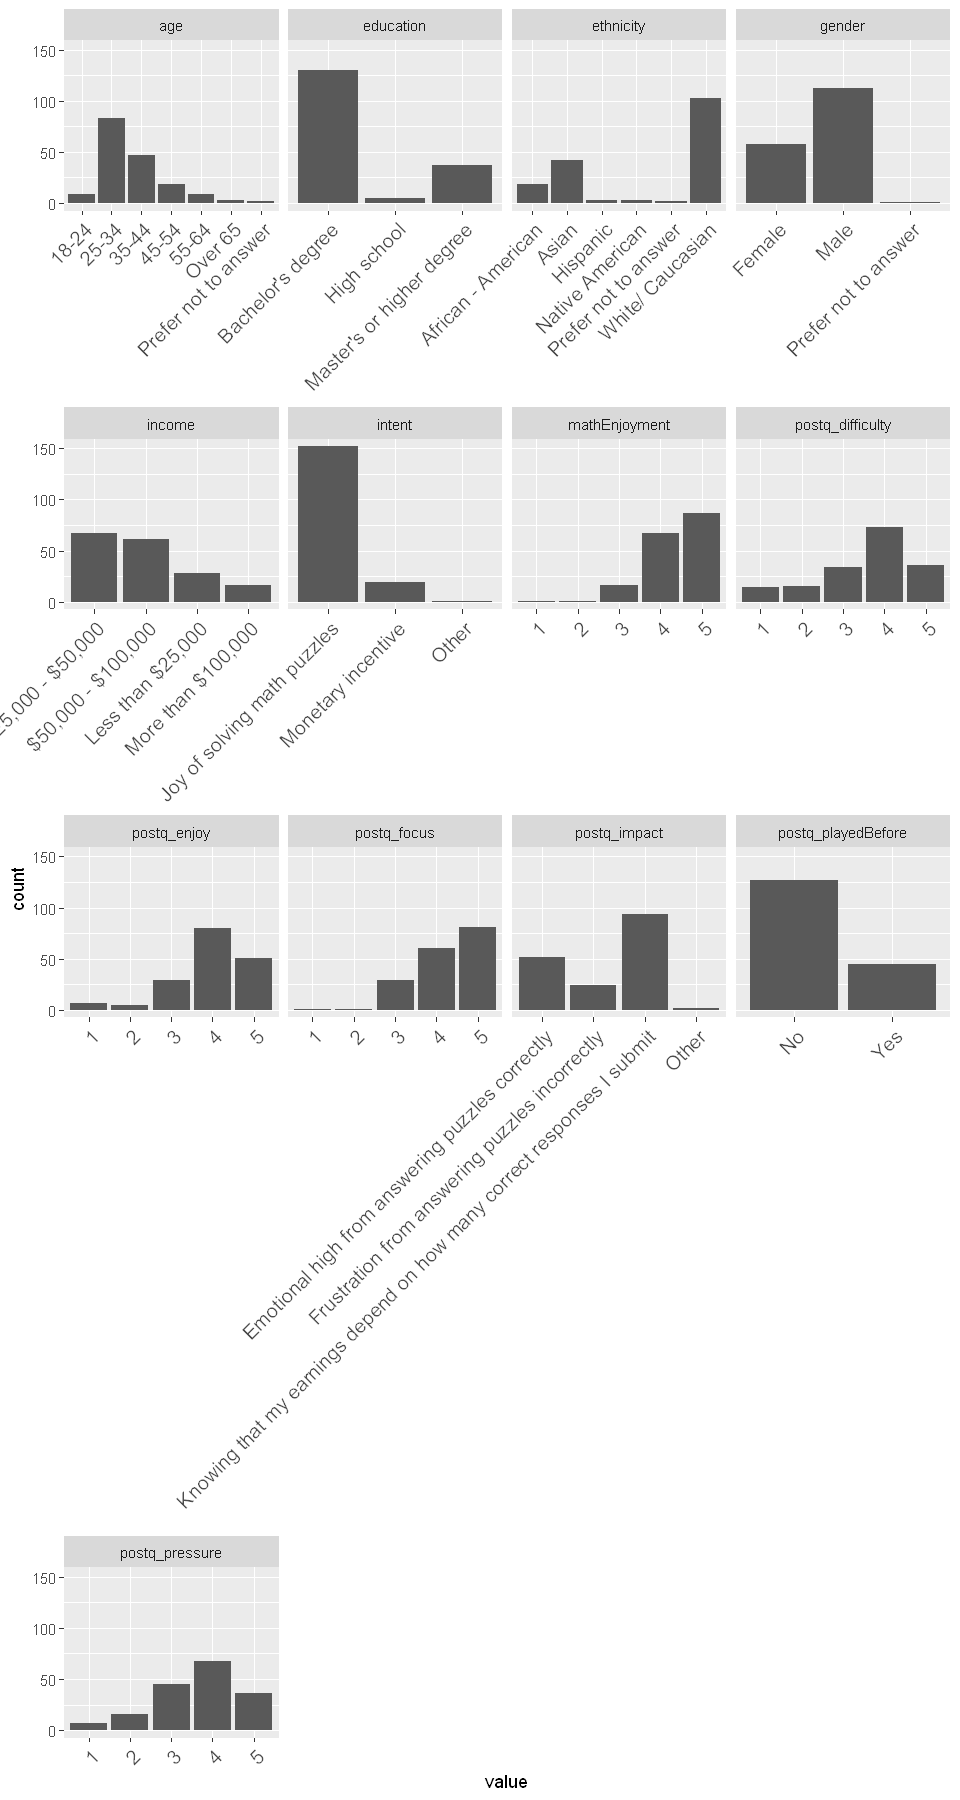

In [113]:
colsToPlot = c('gender', 'age', 'ethnicity', 'education', 'income', 'intent', 'mathEnjoyment',
                'postq_playedBefore', 'postq_enjoy', 'postq_difficulty', 'postq_focus', 'postq_pressure',
                'postq_impact'
               )

options(repr.plot.width=8, repr.plot.height=15)

ggplot(gather(cleanedData[, ..colsToPlot]), aes(value)) + 
    geom_bar() +
    facet_wrap(~key, scales = 'free_x') +
    theme(axis.text.x=element_text(angle=45,hjust=1, size=12))

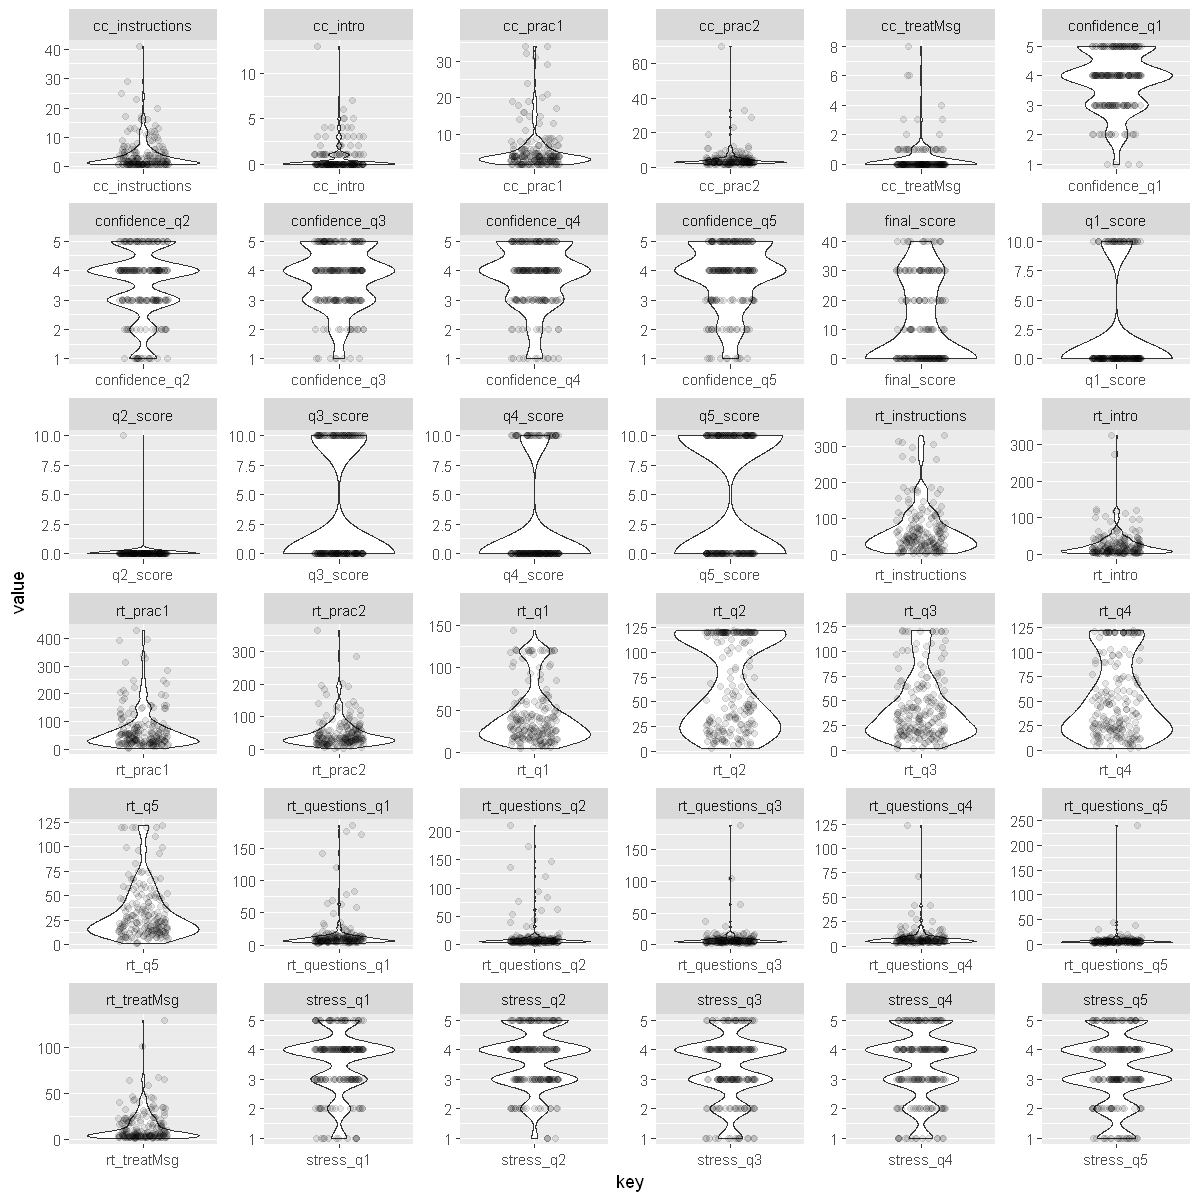

In [164]:
# histogram of all columns

options(repr.plot.width=10, repr.plot.height=10)

colsToPlot = c('rt_intro', 'cc_intro',
                'rt_instructions', 'cc_instructions',
                'rt_prac1', 'cc_prac1',
                'rt_prac2', 'cc_prac2',
                'rt_treatMsg', 'cc_treatMsg',
                'rt_q1', 'rt_questions_q1', 'stress_q1', 'confidence_q1',
                'rt_q2', 'rt_questions_q2', 'stress_q2', 'confidence_q2',
                'rt_q3', 'rt_questions_q3', 'stress_q3', 'confidence_q3',
                'rt_q4', 'rt_questions_q4', 'stress_q4', 'confidence_q4',
                'rt_q5', 'rt_questions_q5', 'stress_q5', 'confidence_q5',
                'q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score', 'final_score'
               )
dataToPlot = data.table(sapply(cleanedData[, ..colsToPlot], as.numeric))

ggplot(gather(a), aes(x=key,y=value)) + 
    geom_violin() + 
    geom_jitter(position=position_jitter(0.2), alpha=0.1) +
    facet_wrap(~key, scales = 'free') 

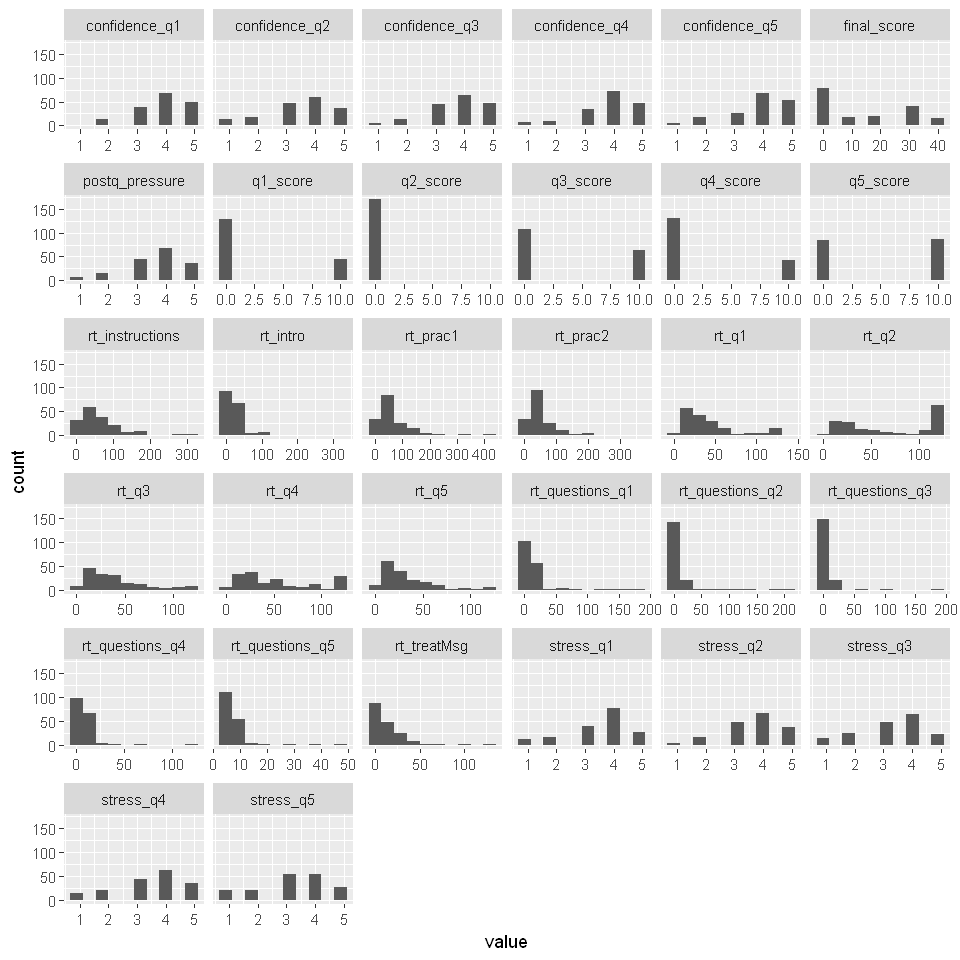

In [100]:
# histogram of all columns

options(repr.plot.width=8, repr.plot.height=8)

colsToPlot = c('rt_intro',
                'rt_instructions',
                'rt_prac1',
                'rt_prac2',
                'rt_treatMsg',
                'rt_q1', 'rt_questions_q1', 'stress_q1', 'confidence_q1',
                'rt_q2', 'rt_questions_q2', 'stress_q2', 'confidence_q2',
                'rt_q3', 'rt_questions_q3', 'stress_q3', 'confidence_q3',
                'rt_q4', 'rt_questions_q4', 'stress_q4', 'confidence_q4',
                'rt_q5', 'rt_questions_q5', 'stress_q5', 'confidence_q5',
                'q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score', 'final_score', 'postq_pressure'
               )
dataToPlot = data.table(sapply(cleanedData[, ..colsToPlot], as.numeric))

ggplot(gather(dataToPlot), aes(value)) + 
    geom_histogram(bins = 10) + 
    facet_wrap(~key, scales = 'free_x') +
    theme(plot.title=element_text(size=12))